# ELTDM Project for ENSAE

##### by Jean-Michel Roufosse - Master Data Science @ ENSAE ParisTech

Reinforcement learning is very trendy nowadays, especially ever since Google's AlphaGo beat some of the worlds best Go players. How did they manage to teach a computer how to play a game, and more importantly, how to win it ?

The research team at Deepmind showed AlphaGo a large number of strong amateur games to help it develop its own understanding of what reasonable human play looks like. Then they had it play against different versions of itself thousands of times, each time learning from its mistakes and incrementally improving until it became immensely strong, and that is what is known as reinforcement learning.

We won't be dealing with the game of Go in this project, but we did use OpenAI Gym, a website that provides ready-to-use classic reinforcement learning environments. The OpenAI Gym provides many standard environments for people to test their reinforcement algorithms. These environments include classic games like Atari Breakout and Doom, and simulated physical environments like CartPole, the example used in this project.

Below is a part of code that illustrates in Jupyter what the CartPole example game looks like. We need to stabilize the pole for as long as possible, while staying in a certain range. GIF might not be visible through GitHub.


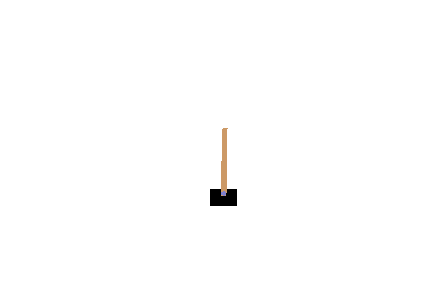
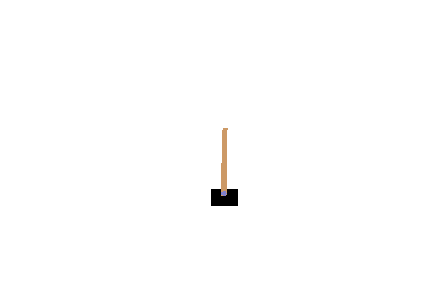
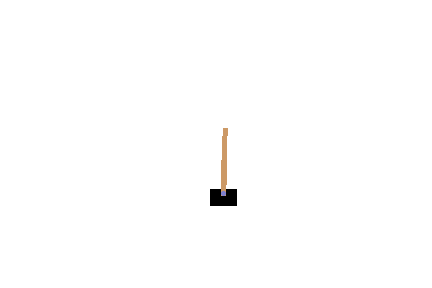
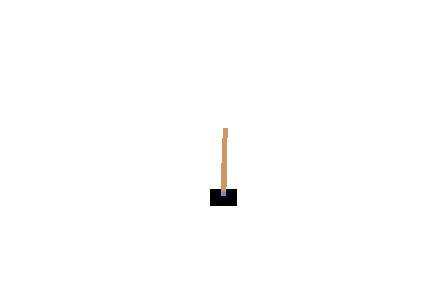
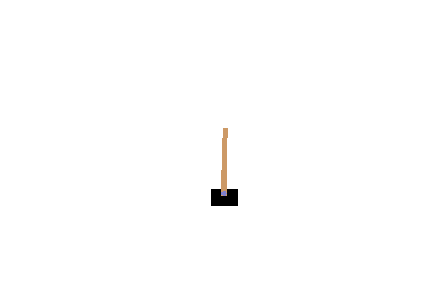
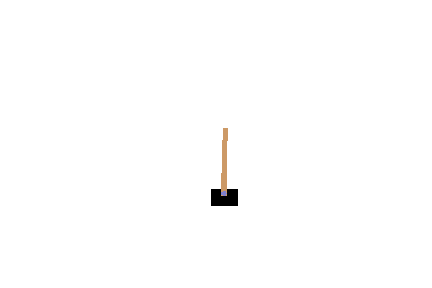
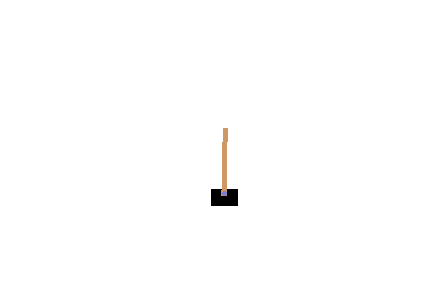
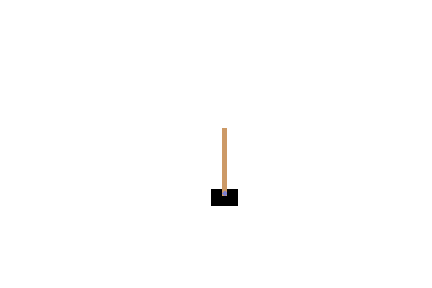
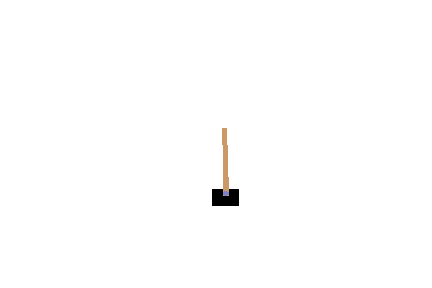
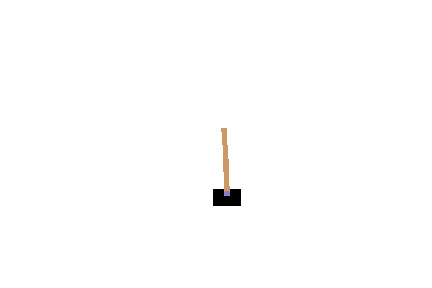
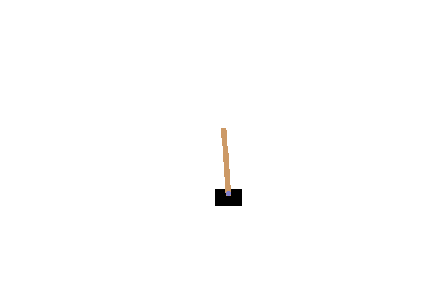
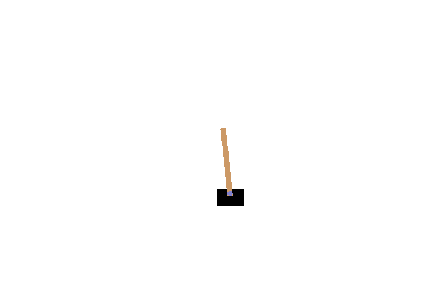
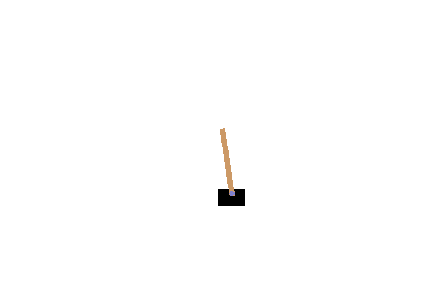
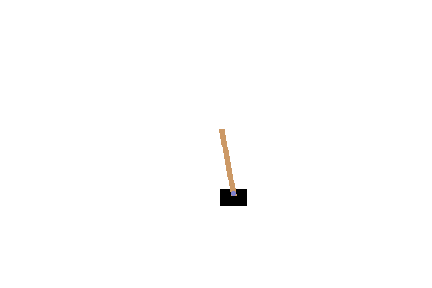

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

env = gym.make('CartPole-v0')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)

At every time step, you can observe its position $x$, velocity $\dot{x}$, angle $\theta$, and angular velocity $\dot{\theta}$. These are the observable states of this world. At any state, the cart only has two possible actions: move to the left or move to the right. In other words, the state-space of the Cart-Pole has four dimensions of continuous values and the action-space has one dimension of two discrete values.

The idea behing Reinforcement Learning is therefore to decide of the best action to perform according to the information given by the game's environment. In the CartPole's case, the action is either $+1$ or $-1$, indicating if the cart should go to the right or left. So, in short, there's a constant dialogue between an Agent, usually a human playing but here it will be a computer, and the Environment, here the CartPole game.

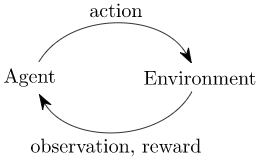

In [2]:
from IPython.display import Image
Image('Agent-Env-Loop.png')

Here comes the notion of reward. It's crucial because the Agent's role is to maximise that reward, since it's highly correlated to chance of winning the game. Here the reward will be a number between 0 and 200, 200 meaning the game was won because the pole successfully didn't fall.

We must first illustrate the math behind Q-Learning in order to program it.

Like explained in the paper, we consider the standard reinforcement learning setting where an agent interacts with an environment $E$ over a number of discrete time steps. At each time step $t$, the agent receives a state st and selects an action at from some set of possible actions $A$ according to its policy $\pi$, where $\pi$ is a mapping from states $s_t$ to actions at. In return, the agent receives the next state $s_{t+1}$ and receives a scalar reward $r_t$. The process continues until the agent reaches a terminal state after which the process restarts. The return $R_t = \sum^{\infty}_{k=0} \gamma^k r_{t+k}$ is the total accumulated return from time step $t$ with discount factor $\gamma \in [0, 1]$. The goal of the agent is to maximize the expected return from each state $s_t$.

The action value $Q^{\pi}(s, a) = \mathbb{E}[R_t|s_t = s, a]$ is the expected return for selecting action $a$ in state $s$ and following policy $\pi$. The optimal value function $Q^{∗}(s, a) = \max_{\pi} Q^{\pi}(s, a)$ gives the maximum action value for state $s$ and action $a$ achievable by any policy. Similarly, the value of state $s$ under policy $\pi$ is defined as $V^{\pi}(s) = \mathbb{E}[R_t|s_t = s]$ and is simply the expected return for following policy $\pi$ from state $s$.

All this said, Q-learning is the method that aims to directly approximate the optimal action value function: $Q^{*}(s, a) \approx Q(s, a; θ)$. In one-step Q-learning, the parameters $\theta$ of the action value function $Q(s, a; \theta) $ are learned by iteratively minimizing a sequence of loss functions, there the *i*th loss function defined as: $$L_i(\theta_i) =  \mathbb{E} \left (r + \gamma \max_{a'} Q(s',a';\theta_{i-1})-Q(s,a;\theta_i) \right ) ^2$$ 

where $s'$ is the state encountered after state $s$.

Our goal will be to implement these functions using a Deep Neural Network and compare results using GPU or not.

# Using GPU

My computer is equiped with a NVIDIA GeForce 740M GPU. Since the GPU is NVIDIA, CUDA and its library for deep neural networks cuDNN are used. cuDNN is an NVIDIA library with functionality used by deep neural network. By default, Theano will detect if it can use cuDNN. If so, it will use it. Finally we configured Theano to run on GPU with CUDA.

In Theano, we use one hidden layer with 200 hidden units, RELU as the Activation function, and Mean-Squared Error as the Loss function. We had to manually define the hidden layers, then stack them. For the back-propagation of the error term, we compute the gradient of the loss with respect to the weights of each layer.

*Code in Theano and Keras being similar for the Q-learning, only the Keras part is commented.*

## Theano

###### Imports

In [3]:
import sys
import timeit
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import gym
import keras
import numpy as np
import scipy
import math
import json
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.models import model_from_json
import time
import operator

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###### Definition of the Neural Network with Theano

In [4]:
def relu(X):
    X[np.where(X < 0)] = 0
    return(X)

class Hidden_Layer(object):
    def __init__(self, input, n_in, n_out, W=None, b=None):

        self.input = input
        if W is None:
            W_values = np.asarray(
                np.random.uniform(low=-0.1,high=0.1,size=(n_in,  n_out)),
                dtype=theano.config.floatX)
            W_h = theano.shared(value = W_values, name='W_h', borrow=True)
            
        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b_h = theano.shared(value=b_values, name='b_h', borrow=True)

        self.W_h = W_h
        self.b_h = b_h
        
        self.params = [self.W_h, self.b_h] # Parameters of the model
        
        self.output = T.nnet.relu(T.dot(input, self.W_h) + self.b_h)

        self.input = input

class Output_Layer(object):

    def __init__(self, input, n_in, n_out):
        
 
        self.W = theano.shared(
            value=np.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )

        self.b = theano.shared(
            value=np.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )

        self.y_pred = T.dot(input, self.W) + self.b

        self.params = [self.W, self.b]

        self.input = input

    def mse(self, y):
        return T.mean((self.y_pred - y) ** 2) 
       
class Neural_Network(object):
    
    def __init__(self, input, n_in, n_hidden, n_out):

        self.hiddenLayer = Hidden_Layer(
            input=input,
            n_in= n_in,
            n_out=n_hidden,
        )

        self.output_layer = Output_Layer(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )


        self.mse = (
            self.output_layer.mse
        )

        self.params = self.hiddenLayer.params + self.output_layer.params
        
        self.input = input
        
def train_on_batch(dataset_X, dataset_y, classifier, x,y,index,learning_rate=0.01, batch_size=1, n_hidden=500):

    train_set_x = theano.shared(np.asarray(dataset_X,
                                            dtype=theano.config.floatX),
                                borrow=True)
    train_set_y = theano.shared(np.asarray(dataset_y,
                                            dtype=theano.config.floatX),
                                borrow=True)

    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size



    cost = (
        classifier.mse(y)
    )

    gparams = [T.grad(cost, param) for param in classifier.params]
    
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]


    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
  
    start_time = timeit.default_timer()

    error = []
    error_min = np.inf
    for minibatch_index in range(n_train_batches):
        minibatch_avg_cost = train_model(minibatch_index)
        linear_1 = np.dot(dataset_X, classifier.hiddenLayer.W_h.eval()) +  classifier.hiddenLayer.b_h.eval()
        h1 = relu(linear_1)
        output_nn = np.dot(h1,classifier.output_layer.W.eval()) + classifier.output_layer.b.eval()
        error.append(np.mean((output_nn - dataset_y)**2))

    end_time = timeit.default_timer()
    
    return(error, classifier.hiddenLayer.W_h.eval(), classifier.hiddenLayer.b_h.eval(), classifier.output_layer.W.eval(), classifier.output_layer.b.eval())

def predict_NN(X_input, W1, b1, Wo, bo):
    return(np.dot(relu(np.dot(X_input,W1) + b1),Wo) + bo)

###### Agent Class

In [5]:
class Agent_Theano(object):
    
    
    def __init__(self, max_memory=100, discount=.9):
        
        """Define max length of memory and gamma"""
         
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remind(self, states, game_over):

        """Add experience to memory"""
        
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, W1, b1, Wo, bo, batch_size=10):
        
        """Get the batch input and targets we will train on"""
        
        len_memory = len(self.memory)
        num_actions = 2
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        targets = np.zeros((inputs.shape[0], num_actions))
        
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]
            inputs[i:i+1] = state_t
            targets[i] = predict_NN(state_t, W1, b1, Wo, bo)
            Q_sa = np.max(targets[i])
            if game_over:
                targets[i, action_t] = reward_t
            else:
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

###### CartPole on OpenAI Gym and Parameters

In [6]:
env = gym.make('CartPole-v0')

learning_rate=0.1
epsilon = .1
num_actions = env.action_space.n 
max_memory = 4000000000
hidden_size = 200
batch_size = 50
acc_reward=0
observation_shape = env.observation_space.shape[0]
time_step=0
max_time_steps=3000
everyC=50
agent = Agent_Theano(max_memory=max_memory)
win_cnt = 0
actual_total=0
e=0
t0 = time.time()


print('Parameters :','epsilon :', epsilon,'C :', everyC,', learning rate :',
      learning_rate, 'batch size for training :', batch_size)

N = 6
X = np.random.uniform(low=-5.,high=5.,size=(N, 4)).astype('float32')
W = np.random.uniform(low=-5.,high=5.,size=(4, 2)).astype('float32')
b = np.random.uniform(low=-5.,high=5.,size=2).astype('float32') 

noise = np.random.normal(0,1,(N,2))

y = np.dot(X**2,W) + 5*np.dot(X,W) +  b + noise
y=y.astype('float32')


# Allocating variables for the data
index = T.lscalar()  
x = T.matrix('x') 
y_g = T.matrix('y')  
# Neural Net Classifier
classifier = Neural_Network(input=x,n_in=4,n_hidden=hidden_size,n_out=2)

#Initializing a random backpropagation
err, W1, b1, Wo, bo = train_on_batch(X, y, classifier, x=x,y=y_g,index=index, learning_rate=0.0003, batch_size=N)

Parameters : epsilon : 0.1 C : 50 , learning rate : 0.1 batch size for training : 50


##### Training the algorithm

In [7]:
print('Training for ',max_time_steps,'time-steps ...')

while time_step<max_time_steps:
    loss = 0.
    acc_reward = 0
    C=0
    e+=1
    input_t = env.reset()
    input_t = input_t.reshape((1,observation_shape))
    game_over = False
    
    while not game_over:

        input_tm1 = input_t.astype('float32')
        
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, num_actions, size=1)[0]
        else:
            q = predict_NN(input_tm1, W1, b1, Wo, bo)
            action = np.argmax(q)

        input_t, reward, game_over, infodemerde = env.step(action)
        input_t = input_t.reshape((1,observation_shape))
        
        acc_reward += reward

        agent.remind([input_tm1, action, reward, input_t], game_over)

        inputs, targets = agent.get_batch(W1, b1, Wo, bo, batch_size=batch_size)
        inputs=inputs.astype('float32')
        targets=targets.astype('float32')

        t2 = time.time()  #start of actual training time

        #TRAIN
        err, W1, b1, Wo, bo = train_on_batch(inputs, targets, classifier, x=x, y=y_g, index=index, learning_rate=learning_rate, batch_size=len(inputs))

        t3 = time.time() #end of actual training time
        actual_total += t3-t2

        time_step += 1

        if acc_reward>=200:
            game_over=True
            win_cnt+=1

    print(time_step,'time steps done, ',e,'episodes done. Reward :', acc_reward, ', loss :', err[0])

t1 = time.time() #end of training time
total = t1-t0
print('Total training time :', total,'Actual training time :', actual_total)
print('Win ratio (nb of games won/nb of games played) :', win_cnt/e)

Training for  3000 time-steps ...
8 time steps done,  1 episodes done. Reward : 8.0 , loss : 0.29904463332082354
17 time steps done,  2 episodes done. Reward : 9.0 , loss : 0.4951476437339578
26 time steps done,  3 episodes done. Reward : 9.0 , loss : 0.5425996883471856
34 time steps done,  4 episodes done. Reward : 8.0 , loss : 1.1527248978544737
43 time steps done,  5 episodes done. Reward : 9.0 , loss : 0.4160094063703441
52 time steps done,  6 episodes done. Reward : 9.0 , loss : 1.1516658439908567
61 time steps done,  7 episodes done. Reward : 9.0 , loss : 0.5249707605703775
71 time steps done,  8 episodes done. Reward : 10.0 , loss : 0.12011496624194067
81 time steps done,  9 episodes done. Reward : 10.0 , loss : 0.27881161466624715
91 time steps done,  10 episodes done. Reward : 10.0 , loss : 0.29061886339871557
101 time steps done,  11 episodes done. Reward : 10.0 , loss : 0.36768737058025996
111 time steps done,  12 episodes done. Reward : 10.0 , loss : 0.7924767117469483
120 

1275 time steps done,  101 episodes done. Reward : 11.0 , loss : 2.158126045097474
1284 time steps done,  102 episodes done. Reward : 9.0 , loss : 0.3860300078793304
1294 time steps done,  103 episodes done. Reward : 10.0 , loss : 0.39554290161116207
1303 time steps done,  104 episodes done. Reward : 9.0 , loss : 0.5705787734733492
1311 time steps done,  105 episodes done. Reward : 8.0 , loss : 0.17415552386450847
1320 time steps done,  106 episodes done. Reward : 9.0 , loss : 0.9537835115795916
1330 time steps done,  107 episodes done. Reward : 10.0 , loss : 0.14061360223989885
1339 time steps done,  108 episodes done. Reward : 9.0 , loss : 0.28426421614988656
1350 time steps done,  109 episodes done. Reward : 11.0 , loss : 0.4952682363273228
1361 time steps done,  110 episodes done. Reward : 11.0 , loss : 0.3896040123801635
1371 time steps done,  111 episodes done. Reward : 10.0 , loss : 0.2379204805515699
1381 time steps done,  112 episodes done. Reward : 10.0 , loss : 0.40504722935

2261 time steps done,  199 episodes done. Reward : 8.0 , loss : 0.44087704880124146
2271 time steps done,  200 episodes done. Reward : 10.0 , loss : 0.21854245516340925
2281 time steps done,  201 episodes done. Reward : 10.0 , loss : 0.19851250107693066
2291 time steps done,  202 episodes done. Reward : 10.0 , loss : 0.3973322223123934
2301 time steps done,  203 episodes done. Reward : 10.0 , loss : 0.14704834722861557
2313 time steps done,  204 episodes done. Reward : 12.0 , loss : 0.2380701032636433
2327 time steps done,  205 episodes done. Reward : 14.0 , loss : 0.1783171448518998
2337 time steps done,  206 episodes done. Reward : 10.0 , loss : 0.2846959623331189
2352 time steps done,  207 episodes done. Reward : 15.0 , loss : 0.25604893915835636
2363 time steps done,  208 episodes done. Reward : 11.0 , loss : 0.5211400015641826
2373 time steps done,  209 episodes done. Reward : 10.0 , loss : 0.24840317184754493
2385 time steps done,  210 episodes done. Reward : 12.0 , loss : 0.2993

##### Testing the algorithm

In [8]:
#nb of episodes to test
nb_e_test=10

#Total reward over the episodes
total_rew=0

print('Testing for ',nb_e_test,'episodes ...')

for episode in range(nb_e_test):
    acc_reward = 0
    input_t = env.reset()
    input_t = input_t.reshape((1,observation_shape))
    game_over = False

    while not game_over:
        input_tm1 = input_t.astype('float32')
        
        q = predict_NN(input_tm1, W1, b1, Wo, bo)
        action = np.argmax(q[0])

        input_t, reward, game_over, infodemerde = env.step(action)
        input_t = input_t.reshape((1,observation_shape))
        
        acc_reward += reward

        if acc_reward>=200:
            game_over=True
            
    total_rew+=acc_reward

    print(episode,'episodes done. Reward :', acc_reward)


print('The average reward over the test was :',total_rew/nb_e_test)

Testing for  10 episodes ...
0 episodes done. Reward : 8.0
1 episodes done. Reward : 8.0
2 episodes done. Reward : 10.0
3 episodes done. Reward : 9.0
4 episodes done. Reward : 10.0
5 episodes done. Reward : 9.0
6 episodes done. Reward : 10.0
7 episodes done. Reward : 9.0
8 episodes done. Reward : 10.0
9 episodes done. Reward : 8.0
The average reward over the test was : 9.1


## Keras

###### Imports

In [9]:
import gym
import theano
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import json
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.models import model_from_json
import time
import operator

###### Agent Class

In [10]:
class Agent_Keras(object):
     
    def __init__(self, max_memory=100, discount=.9):
        """Define max length of memory and gamma"""
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remind(self, states, game_over):      
        """Add experience to memory"""
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:         #Delete the first experience if the memory is too long
            del self.memory[0]

    def get_batch(self, target_model, model, batch_size=10):
        """Get the batch input and targets we will train on"""
        len_memory = len(self.memory)           #length of memory vector
        num_actions = model.output_shape[-1]    #number of actions in action space
        
                                                #states is an experience : [input_t_minus_1, action, reward, input_t],
        env_dim = self.memory[0][0][0].shape[1] #so memory[0] is state and memory[0][0][0].shape[1] is the size of the input
        
                                                
        inputs = np.zeros((min(len_memory, batch_size),#if batch_size<len_memory (it is mostly the case), 
                           env_dim))                   #then input is a matrix with batch_size rows and size of obs columns
        
                                                          #Targets is a matrix with batch_size rows and 
        targets = np.zeros((inputs.shape[0], num_actions))#number of actions columns
        
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            
            #get experience number idx, idx being a random number in [0,length of memory]
            #There are batch_size experiences that are drawn
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            game_over = self.memory[idx][1]     #Is the game over ? if done in gym

            inputs[i:i+1] = state_t             #The inputs of the NN are the state of the experience drawn
            
                                                          # target_model.predict(state_t)[0] is the 
            targets[i] = target_model.predict(state_t)[0] #vector of Q(state_t) for each action 
            
                                                #Q_sa=Q_target(s,argmax_a'{Q(s',a')}
                                                #index is the action you that maximizes the Q-value of the current network
            index, maxima = max(enumerate(model.predict(state_tp1)[0]), key=operator.itemgetter(1))
                                                            #We take the value of the target
            Q_sa = target_model.predict(state_tp1)[0][index]#network for action index
            
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                                                                       # the target for this particular experience is : 
                targets[i, action_t] = reward_t + self.discount * Q_sa #reward_t + gamma * max_a' Q(s', a')
        return inputs, targets

###### Environment and Parameters

In [11]:
env = gym.make('CartPole-v0')  

learning_rate=0.001             #learning rate
epsilon = .1                    #exploration parameter
num_actions = env.action_space.n#Number of possible actions
max_memory = 4000000000         #Length of memory
hidden_size = 200               #Number of hidden units
batch_size = 50                 #Size of batch for training
acc_reward=0                    #Accumulated reward over epoch
time_step=0                     #counter of time-steps
max_time_steps=3000             #total number of time-steps to train on
everyC=5                        #Number of times we update the target network
C=0                             #Parameter C

#shape of observations
observation_shape = env.observation_space.shape[0]

###### Adam Optimizer

In [12]:
Adam=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipvalue=1)

###### Current DNN

In [13]:
model = Sequential()
model.add(Dense(hidden_size, input_dim=observation_shape, activation='relu')) #first fully connected layer, activation RELU
model.add(Dense(num_actions))                                         #last fully connected layer, output Q(s,a,theta)

model.compile(optimizer=Adam, loss='mean_squared_error')              #choose optimization parameters

Instructions for updating:
keep_dims is deprecated, use keepdims instead


###### Target DNN

In [14]:
target_model = Sequential()
target_model.add(Dense(hidden_size, input_dim=observation_shape, activation='relu'))#first fully connected layer, activation RELU
target_model.add(Dense(num_actions))                                        #last fully connected layer, output Q(s,a,theta)
target_model.compile(optimizer=Adam, loss='mean_squared_error')             #choose optimization parameters

###### Initializing the Experience Replay object

In [15]:
agent = Agent_Keras(max_memory=max_memory)

win_cnt = 0      #nb of games won
t0 = time.time() #start of traning time
actual_total=0   #actual training time
e=0              #nb of episodes

print('Parameters :','epsilon :', epsilon,'C :', everyC,', learning rate :', learning_rate, 'batch size for training :', batch_size)

print(model.summary())

print('Training for ',max_time_steps,'time-steps ...')

Parameters : epsilon : 0.1 C : 5 , learning rate : 0.001 batch size for training : 50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1000      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________
None
Training for  2000 time-steps ...


In [16]:
while time_step<max_time_steps:
    loss = 0.       #Set loss to zero
    acc_reward = 0  #Set accumulated reward to 0
    C=0             #Set C to zero
    e+=1            #Add episode
    
    input_t = env.reset()
    input_t = input_t.reshape((1,observation_shape))
    
    game_over = False #Since it's the beginning of the game, game_over is not True

    while not game_over:
        
        input_tm1 = input_t            #set this state to be the last state
        if np.random.rand() <= epsilon:# get next action according to espilon-greedy policy
            #exploration
            action = np.random.randint(0, num_actions, size=1)[0]
        else:
            #exploitation
            q = model.predict(input_tm1)
            action = np.argmax(q[0])

        input_t, reward, game_over, infodemerde = env.step(action) #apply action, get rewards and new state
        input_t = input_t.reshape((1,observation_shape))
        
        acc_reward += reward    #Accumulate reward

        agent.remind([input_tm1, action, reward, input_t], game_over) # store experience
        
        #Create new target network every C updates, by cloning the current network
        if C%everyC==0:
            model.save_weights("model_cartpole_TARGET", overwrite=True)
            with open("model_cartpole_TARGET.json", "w") as outfile:
                json.dump(model.to_json(), outfile) 
            target_model.load_weights("model_cartpole_TARGET")
            

        C += 1         #Increment C
        # get batch we will train on
        inputs, targets = agent.get_batch(target_model, model, batch_size=batch_size)

        t2 = time.time() #start of actual training time
        loss += model.train_on_batch(inputs, targets)
        t3 = time.time() #end of actual training time
        actual_total += t3-t2
        time_step += 1   #increment time-step

        if acc_reward>=200: #end game if max score is reached
            game_over=True
            win_cnt+=1

    print(time_step,'time steps done, ',e,'episodes done. Reward :', acc_reward, ', loss :', loss)

t1 = time.time() #end of training time
total = t1-t0
print('Total training time :', total,'Actual training time :', actual_total)
print('Win ratio (nb of games won/nb of games played) :', win_cnt/e)

9 time steps done,  1 episodes done. Reward : 9.0 , loss : 4.482597440481186
19 time steps done,  2 episodes done. Reward : 10.0 , loss : 4.7649412751197815
29 time steps done,  3 episodes done. Reward : 10.0 , loss : 5.2484195828437805
38 time steps done,  4 episodes done. Reward : 9.0 , loss : 5.54288786649704
48 time steps done,  5 episodes done. Reward : 10.0 , loss : 8.060454785823822
56 time steps done,  6 episodes done. Reward : 8.0 , loss : 8.423350751399994
66 time steps done,  7 episodes done. Reward : 10.0 , loss : 13.036950409412384
74 time steps done,  8 episodes done. Reward : 8.0 , loss : 12.72737991809845
82 time steps done,  9 episodes done. Reward : 8.0 , loss : 13.02591872215271
92 time steps done,  10 episodes done. Reward : 10.0 , loss : 19.00445032119751
100 time steps done,  11 episodes done. Reward : 8.0 , loss : 16.702967643737793
109 time steps done,  12 episodes done. Reward : 9.0 , loss : 13.76010286808014
119 time steps done,  13 episodes done. Reward : 10.

In [17]:
nb_e_test=10  #nb of episodes to test
total_rew=0   #Total reward over the episodes

print('Testing for ',nb_e_test,'episodes ...')

for episode in range(nb_e_test):    #set accumulated reward to 0
    acc_reward = 0
    
    input_t = env.reset()
    input_t = input_t.reshape((1,observation_shape))
    
    game_over = False

    while not game_over:
        
        input_tm1 = input_t

        q = model.predict(input_tm1)
        action = np.argmax(q[0])

        input_t, reward, game_over, infodemerde = env.step(action)
        input_t = input_t.reshape((1,observation_shape))

        acc_reward += reward

        if acc_reward>=200:
            game_over=True

    total_rew+=acc_reward

    print(episode,'episodes done. Reward :', acc_reward)

print('The average reward over the test was :',total_rew/nb_e_test)

Testing for  10 episodes ...
0 episodes done. Reward : 200.0
1 episodes done. Reward : 173.0
2 episodes done. Reward : 131.0
3 episodes done. Reward : 149.0
4 episodes done. Reward : 200.0
5 episodes done. Reward : 200.0
6 episodes done. Reward : 200.0
7 episodes done. Reward : 200.0
8 episodes done. Reward : 200.0
9 episodes done. Reward : 200.0
The average reward over the test was : 185.3


# Time Conclusions

Our results appear on the following Table :

$$\begin{array}{|c|r|r|}
  \hline
\text{Time for training Network in seconds} & CPU & GPU \\ 
  \hline
Theano & 576 & 540\\ 
   \hline
Keras & 30 & 7\\
\hline
\end{array}$$

$$\begin{array}{|c|r|r|}
  \hline
\text{Time for whole algorithm in seconds} & CPU & GPU \\ 
  \hline
Theano & 552 & 585\\ 
   \hline
Keras & 274 & 296\\
\hline
\end{array}$$

As a reminder, the GPU used is a NVIDIA GeForce 740M. The CPU is an Intel Core i7 (2.4GHz). This was done using 3000 steps of training.

It seems that the only improvement of using a GPU is for the time it takes to train a network. Plus, it not being immediate to switch and tell Theano not to use the GPU (By the way, if you have a GPU or not, the times will surely be different). In any case, Keras does perform better on a GPU, roughly $4 \times$ faster. GPU is perfect for matrix multiplication and that is where the difference is made. Indeed, back-propagation is done by differentiation of the loss with respect to the weights and the chain rule, and so calculations are indeed made quicker, especially thanks to the Adam optimizer. 

However, we notice that Theano's results aren't better using GPU. This could be because of my beginner's skils using Theano, and there are still some parts that could be really improved. Plus, there are a lot of dependent steps in the Theano part, which means using a GPU doesn't have an added value. After reading some literature on the subject, having a lot of 'if' statements also aren't well parallelized, which is unfortunetaly the case in that part of the code.

We should note however that the convergence for the Theano part of the code isn't always immediate. Sometimes, the Theano algorithm needs more than 3000 steps to converge, yet sometimes after 1000 steps we already get good scores.

# Conclusions

This project was fully beneficial for me, since I had never worked with Theano nor Keras before. I've been wanting to see what Reinforcement Learning looked like in detail. In addition, I now have my NVIDIA GPU linked up to Python, which is always nice to have, considering it took some time to configure it to my PC's requirements.

Overall, the Q-learning model found is very satisfying according to the score obtained averaging around 200. Whether on Theano or Keras, both scores can be pleasant.